# **Analiza Sezon is Košarkaške Zveze NBA**

Podatki so pobrani iz spletne strani [Basketball Reference](https://www.basketball-reference.com/). Poiskal bom največje število zmag znotraj ene sezone in najbolj dominantno ekipo in leto dominance.

Definiranje konstant in osnovnih funkcij za urejanje podatkov. V funkciji Scraper je dodan `time.sleep(5)` zaradi pogoste napake spletne strani `429 - Too many requests`. Scrapanje traja 3 minute :\)

In [1]:
import requests
from bs4 import BeautifulSoup
import time
import matplotlib.pyplot as plt
import json


ALL_TEAMS = ("ATL", "BOS", "NJN", "CHA", "CHI", "CLE", "DAL", "DEN", "DET", "GSW", 
"HOU", "IND", "LAC", "LAL", "MEM", "MIA", "MIL", "MIN", "NOH", "NYK", "OKC", 
"ORL", "PHI", "PHO", "POR", "SAC", "SAS", "TOR", "UTA", "WAS")

def Scraper(teams: tuple) -> dict:
    """Scrape statistics from the desired teams and year dates"""
    data = dict()
    for team in teams:
        time.sleep(5)
        data[team] = dict()
        request = requests.get(f"https://www.basketball-reference.com/teams/{team}/")
        soup = Table_rows(BeautifulSoup(request.text, 'html.parser'))
        for row in soup[1:]:
            data[team][Season_year(row)] = dict()
            for cell in Table_cells(row):
                name = cell["data-stat"]
                if name not in {"DUMMY", "lg_id", "coaches", "top_ws", "rank_team_playoffs", "team_name"}:
                    data[team][Season_year(row)][name] = cell.text
    with open("data.json", "w") as file:
        json.dump(data, file)
    return data

def Table_rows(soup: str) -> list:
    """Takes HTML5 and returns table rows"""
    return soup.find("table").find_all("tr")

def Table_cells(row):
    """Returns all tables cell from given row"""
    return row.find_all("td")

def Season_year(row):
    """Returns the year of the season"""
    return row.find_all("th")[0].text

data = Scraper(ALL_TEAMS)

# Sortiranje podatkov

Funkcija s katero bom sortiral po zmagah. Napisana je tako, da lahko iščem po katerikoli statistiki.

In [2]:
def Sort_teams(teams: dict[str, dict[str, dict[str, int]]], sort_value: str) -> list[tuple[int, str, str]]:
    scores: list[tuple[int, str, str]] = []
    for team, team_val in teams.items():
        for year, year_val in team_val.items():
            scores.append((int(year_val[sort_value]), year, team))
    return sorted(scores)[::-1]

Spodaj je prikazanih 5 najbolj zmagovitih ekip in sezone v katerih so bile zmage osvojene. Te so Golden State Warriors leta 2016 z 73, Chicago Bulls leta 1996 z 72 in leta 1997 z 69. Los Angeles Lakers leta 1972 z 69 zmagami in Boston Celtics leta 1973 z 68 zmagami.

In [3]:
Sort_teams(data, "wins")[:5]

[(73, '2015-16', 'GSW'),
 (72, '1995-96', 'CHI'),
 (69, '1996-97', 'CHI'),
 (69, '1971-72', 'LAL'),
 (68, '1972-73', 'BOS')]

Naslednja funkcija ločuje ekipe po mojem kriteriju dominance. Sešteje odstotek zmag, število točk v 100ih posegih in število dovoljenih točk v 100ih posegih (to število je negativno zato sem ga spremenil v pozitivnega). Zaradi praznih nizov sem ustvaril pomožno funkcijo ki jih spremeni v ničle.

In [4]:
def Float_Zero(value) -> float:
    try:
        return float(value)
    except:
        return 0.0

def Sort_by_dominance(teams: dict[str, dict[str, dict[str, int]]]) -> list[tuple[int, str, str]]:
    scores: list[tuple[int, str, str]] = []
    for team, team_val in teams.items():
        for year, year_val in team_val.items():
            scores.append(((10 * Float_Zero(year_val["win_loss_pct"]) + (Float_Zero(year_val["off_rtg_rel"]) / 100) + (Float_Zero(year_val["def_rtg_rel"]) / -100)), year, team))
    return sorted(scores)[::-1]

Opazimo, da so najbolj dominantne ekipe tiste, ki so bile tekom let tudi najbolj hvaljene. Te so Golden State Warriors leta 2017, Chicago bulls v koncu 90ih, Los Angeles Lakers v 70ih in Philadelphia 76ers v 60ih.

In [5]:
Sort_by_dominance(data)[:5]

[(9.007, '2015-16', 'GSW'),
 (8.914, '1995-96', 'CHI'),
 (8.53, '1996-97', 'CHI'),
 (8.515, '1971-72', 'LAL'),
 (8.476, '1966-67', 'PHI')]

Pomožna funkcija, ki prešteje kolikokrat se ponovi določeno število v seznamu.

In [6]:
def Count_occurence(data: list[tuple]) -> dict:
    """Counts how many times a number is listed in given list"""
    count = {}
    for i in data:
        wins = i[0]
        if wins in count:
            count[wins] += 1
        else:
            count[wins] = 1
    return count

Opazimo odstopanje v številu sezon z 0 zmagami. To je posledica letošnje sezone, ki se še ni začela/končala.

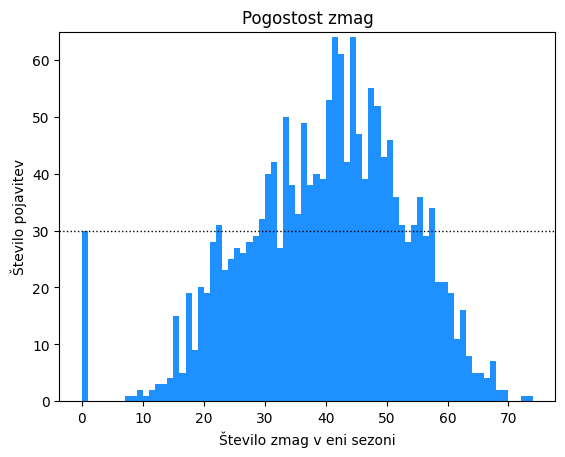

In [7]:
count = list()
for x in Sort_teams(data, "wins"):
    count.append(x[0])

plt.hist(count, bins=range(75), color="dodgerblue")
plt.title("Pogostost zmag")
plt.xlabel("Število zmag v eni sezoni")
plt.ylabel("Število pojavitev")
plt.ylim(0, 65)
plt.axhline(30, color="k", linestyle="dotted", linewidth=1)

# Zaključek

Zaradi načina shranjevanja podatkov v slovarje slovarjev slovarjev sem imel težave z dostopanjem do podatkov in njihovim urejanjem. To je tudi vzrok, zakaj ne berem podatkov iz datoteke, čeprav jih tja shranim. Ne vem kako bi pretvoril niz nazaj v slovar, brez da bi izgubil nekaj njegove strukture ali porabil preveč časa/prostora.

Sprva sem želel ustvariti program, ki bi potekal v ukazni vrstici, vendar sem to opustil zaradi zahtev predmeta.